<a href="https://colab.research.google.com/github/mrtalhim/ttow-ML/blob/main/wayang_mobilenet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Unzip the dataset. The dataset contains 4 classes and needs to be split into train and validation later.

In [54]:
import os
import zipfile

# local_zip = '/content/wayang-new.zip'
local_zip = '/content/wayang-edited-final.zip'
# local_zip = '/content/wayang-final-dataset.zip'

zip_ref = zipfile.ZipFile(local_zip, 'r')

zip_ref.extractall('/content')
zip_ref.close()

In [55]:
base_dir = '/content/augmented/'

In [4]:
IMG_WIDTH = 175
IMG_HEIGHT = 225

IMG_SIZE = (IMG_WIDTH, IMG_HEIGHT)
IMG_SHAPE = IMG_SIZE + (3,)

In [5]:
import tensorflow as tf

In [86]:
train_batch = 40
train_epoch = 40
val_batch = 10
val_epoch = 10

In [87]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1.0/255,
                                   horizontal_flip = True,
                                  #  width_shift_range = 0.1,
                                  #  height_shift_range = 0.1,
                                  #  fill_mode = 'nearest',
                                  #  rotation_range=15,
                                   zoom_range=0.2,
                                   validation_split=0.2
                                   )


train_generator = train_datagen.flow_from_directory(base_dir,
                                                    batch_size=train_batch,
                                                    class_mode='categorical',
                                                    target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                    shuffle=True,
                                                    subset='training')     

validation_generator =  train_datagen.flow_from_directory(base_dir,
                                                         batch_size=val_batch,
                                                         class_mode='categorical',
                                                         target_size=(IMG_HEIGHT, IMG_WIDTH),
                                                         shuffle=True,
                                                         subset='validation')


Found 3575 images belonging to 4 classes.
Found 893 images belonging to 4 classes.


The following block will generate class labels, which will be useful for manual testing below

In [17]:
labels_dict = train_generator.class_indices
# wayang_labels = dict((v, k) for k, v in labels_dict.items())
wayang_labels = list(k for k, _ in labels_dict.items())
print(wayang_labels)

['bagong', 'gareng', 'petruk', 'semar']


Since we are working with imbalanced dataset, we will use class weights in the model. The dictionary used here are calculated from [this notebook](https://github.com/cavannus/ttow-ML/blob/main/data-augment.ipynb).

In [14]:
class_weights = {0: 0.9147058823529411, 1: 1.4136363636363636, 2: 1.0798611111111112, 3: 0.7853535353535354}

print(class_weights)

{0: 0.9147058823529411, 1: 1.4136363636363636, 2: 1.0798611111111112, 3: 0.7853535353535354}


This part defines the model used for transfer learning, which is MobileNetV2.

In [97]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
# base_model.summary()

Fine tuning on MobileNet by unfreezing the first 25 layer of the model.

In [9]:
base_model.trainable = True

for layer in base_model.layers[:25]:
  layer.trainable = False

In [98]:
inputs = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(inputs, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(64)(x)
x = tf.keras.layers.Dense(32)(x)
x = tf.keras.layers.Dense(16)(x)
outputs = tf.keras.layers.Dense(4, activation='softmax')(x)
model = tf.keras.Model(inputs, outputs)

In [99]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=4e-7),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 175, 225, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 6, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_6   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_30 (Dense)            (None, 64)                81984     
                                                                 
 dense_31 (Dense)            (None, 32)                2080      
                                                                 
 dense_32 (Dense)            (None, 16)                528 

In [78]:
class Acc_Callback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if logs['accuracy'] > 0.95:
      print('\nAccuracy is more than 95%')
      self.model.stop_training = True
    elif logs['val_accuracy'] > 0.95:
      print('\nVal-Accuracy is more than 95%')
      self.model.stop_training = True

earlyStop = tf.keras.callbacks.EarlyStopping(monitor='accuracy', min_delta=1e-5, patience=5)

callbacks = [Acc_Callback(),
            #  earlyStop,
             ]

In [100]:
history = model.fit(train_generator,
                    validation_data=validation_generator,
                    steps_per_epoch=train_batch,
                    epochs=train_epoch,
                    validation_steps=val_epoch,
                    verbose=2,
                    callbacks=callbacks,
                    # class_weight=class_weights
                    )

Epoch 1/40
40/40 - 22s - loss: 2.3716 - accuracy: 0.2590 - val_loss: 1.9199 - val_accuracy: 0.3100 - 22s/epoch - 554ms/step
Epoch 2/40
40/40 - 17s - loss: 1.7748 - accuracy: 0.2975 - val_loss: 1.7988 - val_accuracy: 0.2400 - 17s/epoch - 432ms/step
Epoch 3/40
40/40 - 17s - loss: 1.5875 - accuracy: 0.3308 - val_loss: 1.6777 - val_accuracy: 0.3100 - 17s/epoch - 429ms/step
Epoch 4/40
40/40 - 17s - loss: 1.5085 - accuracy: 0.3695 - val_loss: 1.4267 - val_accuracy: 0.4000 - 17s/epoch - 425ms/step
Epoch 5/40
40/40 - 17s - loss: 1.3981 - accuracy: 0.3963 - val_loss: 1.2787 - val_accuracy: 0.4300 - 17s/epoch - 435ms/step
Epoch 6/40
40/40 - 17s - loss: 1.3261 - accuracy: 0.4343 - val_loss: 1.3164 - val_accuracy: 0.4400 - 17s/epoch - 430ms/step
Epoch 7/40
40/40 - 17s - loss: 1.2754 - accuracy: 0.4508 - val_loss: 1.3534 - val_accuracy: 0.4200 - 17s/epoch - 424ms/step
Epoch 8/40
40/40 - 17s - loss: 1.2095 - accuracy: 0.4787 - val_loss: 1.4485 - val_accuracy: 0.3500 - 17s/epoch - 432ms/step
Epoch 9/

Plot the accuracy and loss form training

Text(0.5, 1.0, 'Training and validation loss')

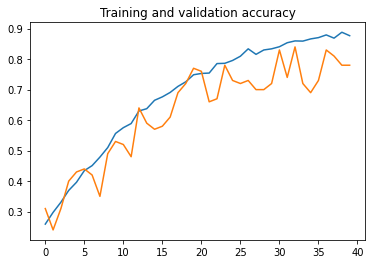

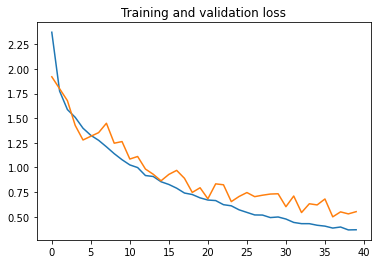

In [101]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc)
plt.plot(epochs, val_acc)
plt.title('Training and validation accuracy')
plt.figure()

plt.plot(epochs, loss)
plt.plot(epochs, val_loss)
plt.title ('Training and validation loss')

In [102]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

Y_pred = model.predict_generator(validation_generator, 893 // val_batch+1)
y_pred = np.argmax(Y_pred, axis=1)
cf_matrix = confusion_matrix(validation_generator.classes, y_pred)
print('Confusion Matrix')
print(cf_matrix)
print('Classification Report')
target_names = wayang_labels
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  after removing the cwd from sys.path.


Confusion Matrix
[[34 64 52 58]
 [42 53 64 65]
 [36 73 55 56]
 [48 64 51 78]]
Classification Report
              precision    recall  f1-score   support

      bagong       0.21      0.16      0.18       208
      gareng       0.21      0.24      0.22       224
      petruk       0.25      0.25      0.25       220
       semar       0.30      0.32      0.31       241

    accuracy                           0.25       893
   macro avg       0.24      0.24      0.24       893
weighted avg       0.24      0.25      0.24       893



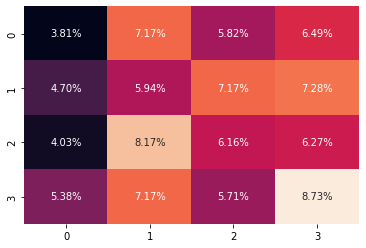

In [103]:
import seaborn as sns
sns.heatmap(cf_matrix / np.sum(cf_matrix),
            annot=True,
            fmt = '.2%',
            cbar = False,)

In [ ]:
import numpy as np
import os
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
  path = '/content/uploaded-test/' + fn
  uploaded_path = '/content/' + fn
  os.replace(uploaded_path, path)
  img = image.load_img(path, target_size=(IMG_WIDTH, IMG_HEIGHT))
  
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  
  classes_pred = model.predict(images, batch_size=10)
  wayang_class = np.argmax(classes_pred)

  print('{} is {}'.format(fn, wayang_labels[wayang_class]))
  print(classes_pred)

This following blocks are for testing purposes

In [ ]:
test_zip = '/content/wayang-test.zip'

zip_ref = zipfile.ZipFile(test_zip, 'r')

zip_ref.extractall('/content')
zip_ref.close()

In [ ]:
test_dir = '/content/test'

test_generator = train_datagen.flow_from_directory(test_dir,
                                                   batch_size=1,
                                                   class_mode='categorical',
                                                   target_size=(IMG_HEIGHT, IMG_WIDTH)) 

Found 120 images belonging to 4 classes.


In [ ]:
model.evaluate(test_generator,
               batch_size=1,
               steps=120,
               verbose=1)

# model.evaluate(train_generator,
#                batch_size=train_batch,
#                steps=train_epoch,
#                verbose=2)

120/120 [==============================] - 1s 8ms/step - loss: 0.0411 - accuracy: 1.0000


[0.04113634675741196, 1.0]

The compiled model are converted into TFLite model, then saved into the system's directory.

In [104]:
modelBaseName = 'wayang-mobilenet-v4'
modelTFLite = modelBaseName + '.tflite'
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open(modelTFLite, 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmprwf5opks/assets


Download converted model into your local system

In [105]:
from google.colab import files

files.download(modelTFLite)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>